Deep Learning
=============

Assignment 3
------------

The goal of this assignment is to train a Word2Vec skip-gram model over [Text8](http://mattmahoney.net/dc/textdata) data.

In [2]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
%matplotlib inline

import collections
import math
import numpy as np
import os
import random
import tensorflow as tf
import zipfile
from matplotlib import pylab
from six.moves import range
from six.moves.urllib.request import urlretrieve
from sklearn.manifold import TSNE

Download the data from the source website if necessary.

In [4]:
url = 'http://mattmahoney.net/dc/'

def maybe_download(filename, expected_bytes):
  """Download a file if not present, and make sure it's the right size."""
  if not os.path.exists(filename):
    filename, _ = urlretrieve(url + filename, filename)
  statinfo = os.stat(filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified %s' % filename)
  else:
    print(statinfo.st_size)
    raise Exception(
      'Failed to verify ' + filename + '. Can you get to it with a browser?')
  return filename

filename = maybe_download('text8.zip', 31344016)

Found and verified text8.zip


Read the data into a string.

In [6]:
def read_data(filename):
  """Extract the first file enclosed in a zip file as a list of words"""
  with zipfile.ZipFile(filename) as f:
    data = tf.compat.as_str(f.read(f.namelist()[0])).split()
  return data
  
words = read_data(filename)
print('Data size %d' % len(words))

Data size 17005207


Build the dictionary and replace rare words with UNK token.

In [7]:
vocabulary_size = 50000

def build_dataset(words):
  count = [['UNK', -1]]
  count.extend(collections.Counter(words).most_common(vocabulary_size - 1))
  dictionary = dict()
  for word, _ in count:
    dictionary[word] = len(dictionary)
  data = list()
  unk_count = 0
  for word in words:
    if word in dictionary:
      index = dictionary[word]
    else:
      index = 0  # dictionary['UNK']
      unk_count = unk_count + 1
    data.append(index)
  count[0][1] = unk_count
  reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys())) 
  return data, count, dictionary, reverse_dictionary

data, count, dictionary, reverse_dictionary = build_dataset(words)
print('Most common words (+UNK)', count[:5])
print('Sample data', data[:10])
del words  # Hint to reduce memory.

Most common words (+UNK) [['UNK', 418391], ('the', 1061396), ('of', 593677), ('and', 416629), ('one', 411764)]
Sample data [5234, 3081, 12, 6, 195, 2, 3134, 46, 59, 156]


Function to generate a training batch for the skip-gram model.

In [ ]:
data_index = 0

def generate_batch(batch_size, num_skips, skip_window):
  global data_index
  assert batch_size % num_skips == 0
  assert num_skips <= 2 * skip_window
  batch = np.ndarray(shape=(batch_size), dtype=np.int64)
  labels = np.ndarray(shape=(batch_size, 1), dtype=np.int64)
  span = 2 * skip_window + 1 # [ skip_window target skip_window ]
  buffer = collections.deque(maxlen=span)
  for _ in range(span):
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  for i in range(batch_size // num_skips):
    target = skip_window  # target label at the center of the buffer
    targets_to_avoid = [ skip_window ]
    for j in range(num_skips):
      while target in targets_to_avoid:
        target = random.randint(0, span - 1)
      targets_to_avoid.append(target)
      batch[i * num_skips + j] = buffer[skip_window]
      labels[i * num_skips + j, 0] = buffer[target]
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  return batch, labels

print('data:', [reverse_dictionary[di] for di in data[:8]])

for num_skips, skip_window in [(2, 1), (4, 2)]:
    data_index = 0
    batch, labels = generate_batch(batch_size=8, num_skips=num_skips, skip_window=skip_window)
    print('\nwith num_skips = %d and skip_window = %d:' % (num_skips, skip_window))
    print('    batch:', [reverse_dictionary[bi] for bi in batch])
    print('    labels:', [reverse_dictionary[li] for li in labels.reshape(8)])

data: ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first']

with num_skips = 2 and skip_window = 1:
    batch: ['originated', 'originated', 'as', 'as', 'a', 'a', 'term', 'term']
    labels: ['as', 'anarchism', 'originated', 'a', 'as', 'term', 'a', 'of']

with num_skips = 4 and skip_window = 2:
    batch: ['as', 'as', 'as', 'as', 'a', 'a', 'a', 'a']
    labels: ['originated', 'anarchism', 'a', 'term', 'originated', 'of', 'term', 'as']


Train a skip-gram model.

In [ ]:
batch_size = 128
embedding_size = 128 # Dimension of the embedding vector.
skip_window = 1 # How many words to consider left and right.
num_skips = 2 # How many times to reuse an input to generate a label.
# We pick a random validation set to sample nearest neighbors. here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent. 
valid_size = 16 # Random set of words to evaluate similarity on.
valid_window = 100 # Only pick dev samples in the head of the distribution.
valid_examples = np.array(random.sample(range(valid_window), valid_size))
num_sampled = 64 # Number of negative examples to sample.

# Variables.
embeddings = tf.Variable(
  tf.random.uniform([vocabulary_size, embedding_size], -1.0, 1.0))
softmax_weights = tf.Variable(
  tf.random.truncated_normal([vocabulary_size, embedding_size],
                        stddev=1.0 / math.sqrt(embedding_size)))
softmax_biases = tf.Variable(tf.zeros([vocabulary_size]))

# Model.
# Look up embeddings for inputs.
def model(data):
  return tf.nn.embedding_lookup(embeddings, data)

# Compute the softmax loss, using a sample of the negative labels each time.
def compute_loss(labels, embed):
  return tf.reduce_mean(
    tf.nn.sampled_softmax_loss(weights=softmax_weights, biases=softmax_biases, inputs=embed,
                               labels=labels, num_sampled=num_sampled, num_classes=vocabulary_size))

# Optimizer.
# Note: The optimizer will optimize the softmax_weights AND the embeddings.
# This is because the embeddings are defined as a variable quantity and the
# optimizer's `minimize` method will by default modify all variable quantities 
# that contribute to the tensor it is passed.
optimizer = tf.keras.optimizers.Adagrad(1.0)



In [ ]:
num_steps = 100001
average_loss = 0

for step in range(num_steps):
  batch_data, batch_labels = generate_batch(
    batch_size, num_skips, skip_window)
  batch_data = tf.convert_to_tensor(batch_data)
  batch_labels = tf.convert_to_tensor(batch_labels)

  with tf.GradientTape() as g:
    embed = model(batch_data)
    loss = compute_loss(batch_labels, embed)

  # Optimizer.
  optimizer.minimize(loss, g.watched_variables(), tape=g)

  average_loss += loss
  if step % 2000 == 0:
    if step > 0:
      average_loss = average_loss / 2000
    # The average loss is an estimate of the loss over the last 2000 batches.
    print('Average loss at step %d: %f' % (step, average_loss))
    average_loss = 0
  # note that this is expensive (~20% slowdown if computed every 500 steps)
  if step % 10000 == 0:
    # Compute the similarity between minibatch examples and all embeddings.
    # We use the cosine distance:
    norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keepdims=True))
    normalized_embeddings = embeddings / norm
    valid_embeddings = tf.nn.embedding_lookup(
      normalized_embeddings, valid_examples)
    similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))

    for i in range(valid_size):
      valid_word = reverse_dictionary[valid_examples[i]]
      top_k = 8 # number of nearest neighbors
      nearest = tf.argsort(-similarity[i, :])[1:top_k+1]
      log = 'Nearest to %s:' % valid_word
      for k in range(top_k):
        close_word = reverse_dictionary[nearest[k].numpy()]
        log = '%s %s,' % (log, close_word)
      print(log)

final_embeddings = normalized_embeddings

Average loss at step 0: 7.862971
Nearest to use: marries, advertise, fridays, bernini, langton, expressionist, eagerness, chastity,
Nearest to their: themes, mohammad, hiding, civilisation, ambient, solicitation, forrester, section,
Nearest to zero: fletcher, perpetrated, wreath, quantitatively, catering, operates, gracie, revising,
Nearest to may: nail, auction, chewed, shorelines, eplf, interscope, crowding, nations,
Nearest to th: viewing, concentrations, solicitation, flask, glazed, harrison, rence, explains,
Nearest to six: repackaged, motive, petitioning, realpolitik, waterway, explorers, fedayeen, wishes,
Nearest to b: lehrer, avc, pital, reinforcing, transsexual, motorised, ramanujan, plunges,
Nearest to nine: witted, pickering, emanuel, chickenpox, emissaries, assistance, calabria, vase,
Nearest to this: effeminate, abercrombie, thrilling, anglian, sle, hass, misr, disintegrating,
Nearest to of: edgerton, baptized, poinsot, clung, unitary, acclaim, kampf, donuts,
Nearest to kn

In [ ]:
num_points = 400

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000, method='exact')
two_d_embeddings = tsne.fit_transform(final_embeddings[1:num_points+1, :])

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


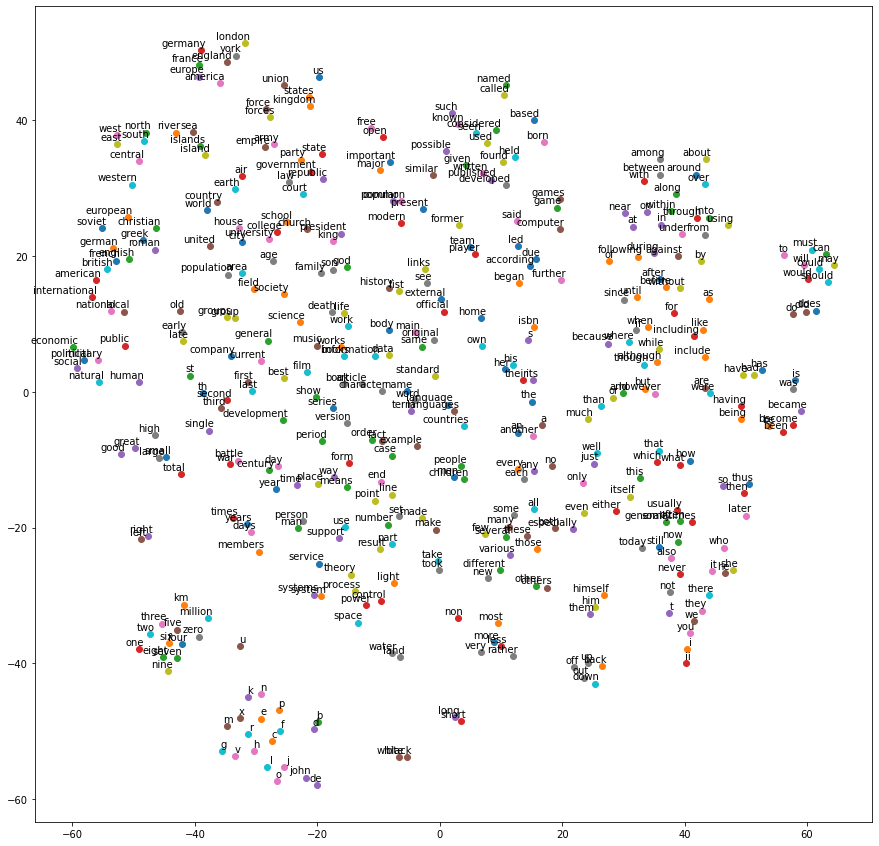

In [ ]:
def plot(embeddings, labels):
  assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
  pylab.figure(figsize=(15,15))  # in inches
  for i, label in enumerate(labels):
    x, y = embeddings[i,:]
    pylab.scatter(x, y)
    pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                   ha='right', va='bottom')
  pylab.show()

words = [reverse_dictionary[i] for i in range(1, num_points+1)]
plot(two_d_embeddings, words)

---

Problem I
-------

An alternative to skip-gram is another Word2Vec model called [CBOW](http://arxiv.org/abs/1301.3781) (Continuous Bag of Words). In the CBOW model, instead of predicting a context word from a word vector, you predict a word from the sum of all the word vectors in its context. Implement and evaluate a CBOW model trained on the text8 dataset.

---

In [8]:
data_index = 0

def generate_cbow_batch(batch_size, bag_window):
    global data_index
    span = 2 * bag_window + 1 # [ bag_window target bag_window ]
    batch = np.ndarray(shape=(batch_size, span - 1), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    buffer = collections.deque(maxlen=span)
    for _ in range(span):
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    for i in range(batch_size):
        # just for testing
        buffer_list = list(buffer)
        labels[i, 0] = buffer_list.pop(bag_window)
        batch[i] = buffer_list
        # iterate to the next buffer
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    return batch, labels

print('data:', [reverse_dictionary[di] for di in data[:16]])

for bag_window in [1, 2]:
    data_index = 0
    batch, labels = generate_cbow_batch(batch_size=4, bag_window=bag_window)
    print('\nwith bag_window = %d:' % (bag_window))
    print('    batch:', [[reverse_dictionary[w] for w in bi] for bi in batch])
    print('    labels:', [reverse_dictionary[li] for li in labels.reshape(4)])

data: ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against', 'early', 'working', 'class', 'radicals', 'including', 'the']

with bag_window = 1:
    batch: [['anarchism', 'as'], ['originated', 'a'], ['as', 'term'], ['a', 'of']]
    labels: ['originated', 'as', 'a', 'term']

with bag_window = 2:
    batch: [['anarchism', 'originated', 'a', 'term'], ['originated', 'as', 'term', 'of'], ['as', 'a', 'of', 'abuse'], ['a', 'term', 'abuse', 'first']]
    labels: ['as', 'a', 'term', 'of']


In [9]:
batch_size = 128
embedding_size = 128  # Dimension of the embedding vector.
bag_window = 2  # How many words to consider left and right.
# We pick a random validation set to sample nearest neighbors. here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent.
valid_size = 16  # Random set of words to evaluate similarity on.
valid_window = 100  # Only pick dev samples in the head of the distribution.
valid_examples = np.array(random.sample(range(valid_window), valid_size))
num_sampled = 64  # Number of negative examples to sample.

# Variables.
embeddings = tf.Variable(
    tf.random.uniform([vocabulary_size, embedding_size], -1.0, 1.0), name="embeddings_var")
softmax_weights = tf.Variable(
    tf.random.truncated_normal([vocabulary_size, embedding_size],
                        stddev=1.0 / math.sqrt(embedding_size)), name="softmax_weights_var")
softmax_biases = tf.Variable(tf.zeros([vocabulary_size]), name="softmax_biases_var")

# Model.
def cbow_model(data):
  return tf.nn.embedding_lookup(embeddings, data)

# Compute the softmax loss, using a sample of the negative labels each time.
def compute_cbow_loss(labels, embed):
  return tf.reduce_mean(
    tf.nn.sampled_softmax_loss(weights=softmax_weights, biases=softmax_biases, inputs=tf.reduce_sum(embed, 1),
                              labels=labels, num_sampled=num_sampled, num_classes=vocabulary_size))

# Optimizer.
optimizer = tf.keras.optimizers.Adagrad(1.0)

In [10]:
num_steps = 100001
average_loss = 0

for step in range(num_steps):
    batch_data, batch_labels = generate_cbow_batch(
        batch_size, bag_window)
    batch_data = tf.convert_to_tensor(batch_data)
    batch_labels = tf.convert_to_tensor(batch_labels)

    with tf.GradientTape() as g:
      embed = cbow_model(batch_data)
      loss = compute_cbow_loss(batch_labels, embed)

    # Optimizer.
    optimizer.minimize(loss, g.watched_variables(), tape=g)

    average_loss += loss

    if step % 2000 == 0:
        if step > 0:
            average_loss = average_loss / 2000
        # The average loss is an estimate of the loss over the last 2000 batches.
        print('Average loss at step %d: %f' % (step, average_loss))
        average_loss = 0
    # note that this is expensive (~20% slowdown if computed every 500 steps)
    if step % 10000 == 0:
        # Compute the similarity between minibatch examples and all embeddings.
        # We use the cosine distance:
        norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keepdims=True))
        normalized_embeddings = embeddings / norm
        valid_embeddings = tf.nn.embedding_lookup(
          normalized_embeddings, valid_examples)
        similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))

        for i in range(valid_size):
          valid_word = reverse_dictionary[valid_examples[i]]
          top_k = 8 # number of nearest neighbors
          nearest = tf.argsort(-similarity[i, :])[1:top_k+1]
          log = 'Nearest to %s:' % valid_word
          for k in range(top_k):
            close_word = reverse_dictionary[nearest[k].numpy()]
            log = '%s %s,' % (log, close_word)
          print(log)
final_embeddings = normalized_embeddings

Average loss at step 0: 8.146644
Nearest to when: qigong, ultimatum, eskimos, budding, wmap, ulvaeus, commemorating, canola,
Nearest to known: maclean, standardization, lothian, broken, enrique, roadside, immutable, su,
Nearest to an: deadline, pleading, pill, beanstalk, nikaya, roadster, voids, upgraded,
Nearest to only: pours, sha, shawl, une, salt, equates, fundamental, portugal,
Nearest to and: pentagram, poles, thorough, eviction, tau, devotee, veracity, bani,
Nearest to states: pi, excommunicated, eigenvalue, ferocity, treviso, epicycle, myasthenia, asset,
Nearest to over: hdl, ethnography, reynard, doonesbury, samsara, ringo, ilo, valuables,
Nearest to years: thirds, unmop, periodicals, disney, gilligan, antidisestablishmentarianism, copenhagen, photosensitive,
Nearest to one: cabral, michelangelo, sala, madero, sutherland, naturalized, tallest, nj,
Nearest to th: gumby, distributor, pablo, hurt, berry, chair, klein, admirable,
Nearest to however: resistive, schl, kumamoto, ncc,

In [11]:
num_points = 400

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
two_d_embeddings = tsne.fit_transform(final_embeddings[1:num_points+1, :])

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


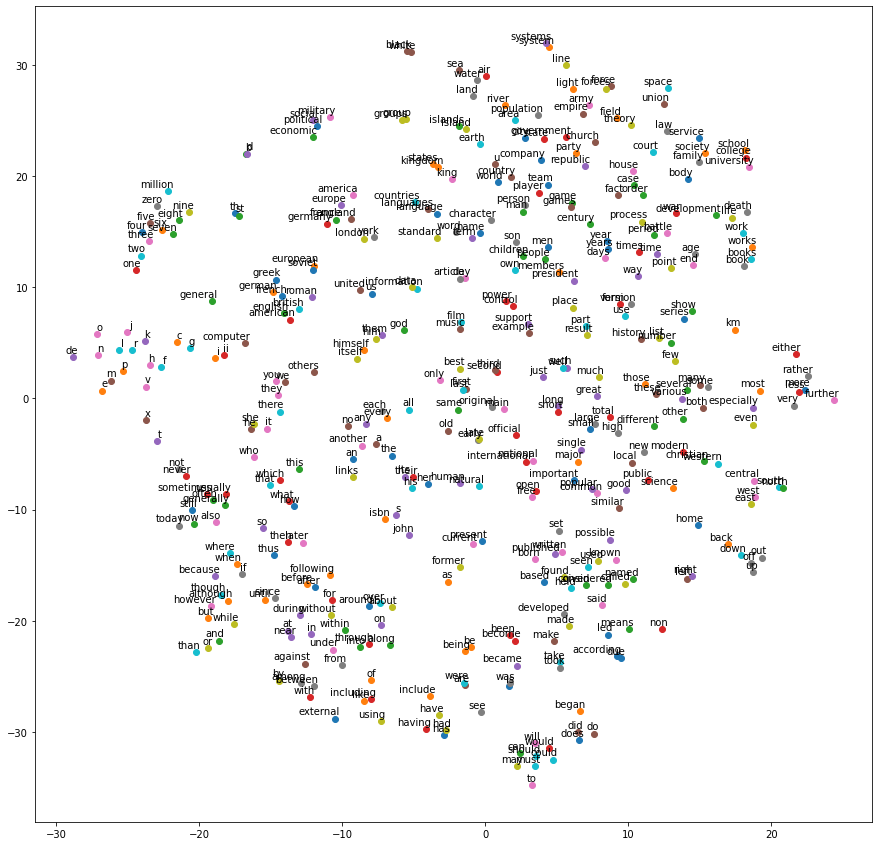

In [12]:
%matplotlib inline

def plot(embeddings, labels):
  assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
  pylab.figure(figsize=(15,15))  # in inches
  for i, label in enumerate(labels):
    x, y = embeddings[i,:]
    pylab.scatter(x, y)
    pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                   ha='right', va='bottom')
  pylab.show()

words = [reverse_dictionary[i] for i in range(1, num_points+1)]
plot(two_d_embeddings, words)

---

Problem II
-------

Implement any of the two word2vec models using graph execution with tf.function instead of running in eager mode.

---

In [14]:
num_steps = 100001
average_loss = 0

graph_model = tf.function(cbow_model)

for step in range(num_steps):
    batch_data, batch_labels = generate_cbow_batch(
        batch_size, bag_window)
    batch_data = tf.convert_to_tensor(batch_data)
    batch_labels = tf.convert_to_tensor(batch_labels)

    with tf.GradientTape() as g:
      embed = graph_model(batch_data)
      loss = compute_cbow_loss(batch_labels, embed)

    # Optimizer.
    optimizer.minimize(loss, g.watched_variables(), tape=g)

    average_loss += loss

    if step % 2000 == 0:
        if step > 0:
            average_loss = average_loss / 2000
        # The average loss is an estimate of the loss over the last 2000 batches.
        print('Average loss at step %d: %f' % (step, average_loss))
        average_loss = 0
    # note that this is expensive (~20% slowdown if computed every 500 steps)
    if step % 10000 == 0:
        # Compute the similarity between minibatch examples and all embeddings.
        # We use the cosine distance:
        norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keepdims=True))
        normalized_embeddings = embeddings / norm
        valid_embeddings = tf.nn.embedding_lookup(
          normalized_embeddings, valid_examples)
        similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))

        for i in range(valid_size):
          valid_word = reverse_dictionary[valid_examples[i]]
          top_k = 8 # number of nearest neighbors
          nearest = tf.argsort(-similarity[i, :])[1:top_k+1]
          log = 'Nearest to %s:' % valid_word
          for k in range(top_k):
            close_word = reverse_dictionary[nearest[k].numpy()]
            log = '%s %s,' % (log, close_word)
          print(log)
final_embeddings = normalized_embeddings

Average loss at step 0: 2.409336
Nearest to when: if, before, where, unless, while, after, actually, never,
Nearest to known: referred, defined, seen, regarded, described, recognized, opposed, viewed,
Nearest to an: another, the, toby, nantes, mitosis, cytoplasmic, telophase, francesco,
Nearest to only: exclusively, always, actually, necessarily, mainly, just, traditionally, best,
Nearest to and: or, but, etc, including, while, however, though, harmonising,
Nearest to states: kingdom, nations, provinces, airlines, ld, undertakings, manchester, emirates,
Nearest to over: across, around, about, throughout, under, beyond, through, norah,
Nearest to years: decades, months, minutes, weeks, days, centuries, hours, seconds,
Nearest to one: ashford, two, auxerre, fiji, awhile, immunoglobulins, euros, donuts,
Nearest to th: twentieth, nd, st, nineteenth, sixteenth, eighteenth, thirteenth, third,
Nearest to however: although, but, though, while, nevertheless, and, despite, where,
Nearest to use: